In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [2]:
min_support = 0.01
conf_values = np.round(np.arange(0.10, 0.61, 0.05), 2)

In [3]:
path = "baskets.csv"
df = pd.read_csv(path, header=None, encoding='cp1251')

transactions = []
for _, row in df.iterrows():
    items = [str(x).strip() for x in row.dropna().tolist() if str(x).strip() != ""]
    transactions.append(sorted(set(items)))

print("Transactions:", len(transactions))
print("Example:", transactions[:3])

Transactions: 7501
Example: [['авокадо', 'батат', 'замороженный смузи', 'зеленый виноград', 'зеленый чай', 'креветки', 'лосось', 'мед', 'миндаль', 'минеральная вода', 'низкокалорийный йогурт', 'овощная смесь', 'оливковое масло', 'салат', 'творог', 'томатный сок', 'цельнозерновая мука', 'шпинат', 'энергетический напиток', 'ягодный сок'], ['гамбургер', 'фрикадельки', 'яйца'], ['чатни']]


In [4]:
te = TransactionEncoder()
onehot = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
print("One-hot shape:", onehot.shape)

One-hot shape: (7501, 115)


In [5]:
max_items_len = 15
t0 = time.perf_counter()
freq_itemsets = apriori(
    onehot,
    min_support=min_support,
    use_colnames=True,
    max_len=max_items_len
)
t1 = time.perf_counter()

freq_itemsets["len"] = freq_itemsets["itemsets"].apply(len)

print("\nFrequent itemsets:", freq_itemsets.shape)
print("Apriori time (sec):", round(t1 - t0, 4))
print("Max itemset length:", int(freq_itemsets["len"].max()) if len(freq_itemsets) else 0)


Frequent itemsets: (261, 3)
Apriori time (sec): 0.1589
Max itemset length: 3


In [6]:
def itemset_to_str(s):
    return "{" + ", ".join(sorted(list(s))) + "}"

def enrich_rules(rules_df):
    if len(rules_df) == 0:
        return rules_df
    rules_df = rules_df.copy()
    rules_df["rule_len"] = rules_df["antecedents"].apply(len) + rules_df["consequents"].apply(len)
    rules_df["rule"] = rules_df.apply(
        lambda r: f"{itemset_to_str(r['antecedents'])} ==> {itemset_to_str(r['consequents'])}",
        axis=1
    )
    return rules_df

In [13]:
summary = []
rules_by_conf = {}
rules_le7_by_conf = {}

for conf in conf_values:
    start = time.perf_counter()
    rules = association_rules(freq_itemsets, metric="confidence", min_threshold=float(conf))
    elapsed = time.perf_counter() - start

    rules = enrich_rules(rules)

    total_rules = int(len(rules))
    max_rule_len = int(rules["rule_len"].max()) if total_rules > 0 else 0
    rules_le7 = rules[rules["rule_len"] <= 7].copy() if total_rules > 0 else rules.copy()
    cnt_le7 = int(len(rules_le7))

    summary.append({
        "confidence": float(conf),
        "time_sec": float(elapsed),
        "total_rules": total_rules,
        "max_rule_length": max_rule_len,
        "rules_len_le7": cnt_le7
    })

    rules_by_conf[float(conf)] = rules
    rules_le7_by_conf[float(conf)] = rules_le7

results_df = pd.DataFrame(summary)
print("\nSummary:")
print(results_df)


Summary:
    confidence  time_sec  total_rules  max_rule_length  rules_len_le7
0         0.10  0.003648          333                3            333
1         0.15  0.003423          231                3            231
2         0.20  0.003142          163                3            163
3         0.25  0.002653           99                3             99
4         0.30  0.002746           65                3             65
5         0.35  0.002579           34                3             34
6         0.40  0.002511           19                3             19
7         0.45  0.002646            6                3              6
8         0.50  0.002476            2                3              2
9         0.55  0.001636            0                0              0
10        0.60  0.001387            0                0              0


In [14]:
def print_top_rules(conf, top_n=30, only_len_le7=True, sort_by="lift"):
    conf = float(conf)
    rules = rules_le7_by_conf[conf] if only_len_le7 else rules_by_conf[conf]

    if len(rules) == 0:
        print(f"\nНет правил для confidence={conf}")
        return

    if sort_by in rules.columns:
        rules = rules.sort_values(sort_by, ascending=False)

    print(f"\nTop rules for confidence={conf} | only_len_le7={only_len_le7} | top={top_n}\n")
    for r in rules.head(top_n)["rule"].tolist():
        print(r)

print_top_rules(0.10, top_n=30, only_len_le7=True, sort_by="lift")
print_top_rules(0.40, top_n=30, only_len_le7=True, sort_by="lift")


Top rules for confidence=0.1 | only_len_le7=True | top=30

{травы и перец} ==> {говяжий фарш}
{говяжий фарш} ==> {травы и перец}
{говяжий фарш} ==> {макароны, минеральная вода}
{макароны, минеральная вода} ==> {говяжий фарш}
{оливковое масло} ==> {макароны, минеральная вода}
{макароны, минеральная вода} ==> {оливковое масло}
{помидоры} ==> {замороженные овощи}
{замороженные овощи} ==> {помидоры}
{креветки} ==> {замороженные овощи}
{замороженные овощи} ==> {креветки}
{минеральная вода, молоко} ==> {замороженные овощи}
{замороженные овощи} ==> {минеральная вода, молоко}
{замороженные овощи, минеральная вода} ==> {молоко}
{говяжий фарш} ==> {минеральная вода, молоко}
{минеральная вода, молоко} ==> {говяжий фарш}
{суп} ==> {молоко}
{молоко} ==> {суп}
{креветки} ==> {помидоры}
{помидоры} ==> {креветки}
{говяжий фарш, минеральная вода} ==> {макароны}
{говяжий фарш} ==> {тертый сыр}
{тертый сыр} ==> {говяжий фарш}
{говяжий фарш} ==> {оливковое масло}
{оливковое масло} ==> {говяжий фарш}
{гов

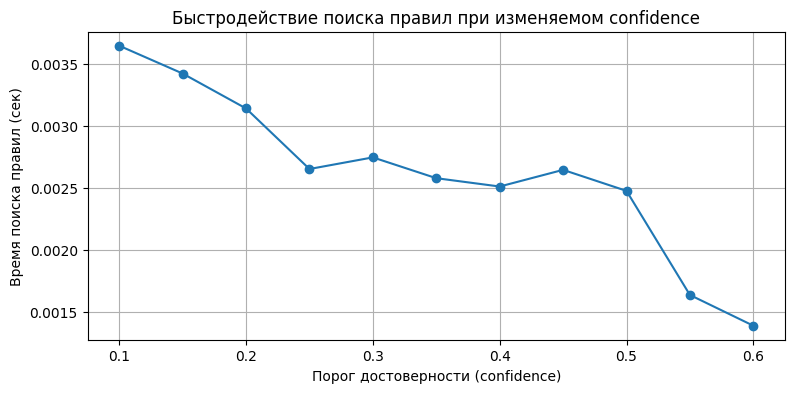

In [15]:
x = results_df["confidence"].values

# 1) быстродействие
plt.figure(figsize=(9,4))
plt.plot(x, results_df["time_sec"], marker="o")
plt.xlabel("Порог достоверности (confidence)")
plt.ylabel("Время поиска правил (сек)")
plt.title("Быстродействие поиска правил при изменяемом confidence")
plt.grid(True)
plt.show()

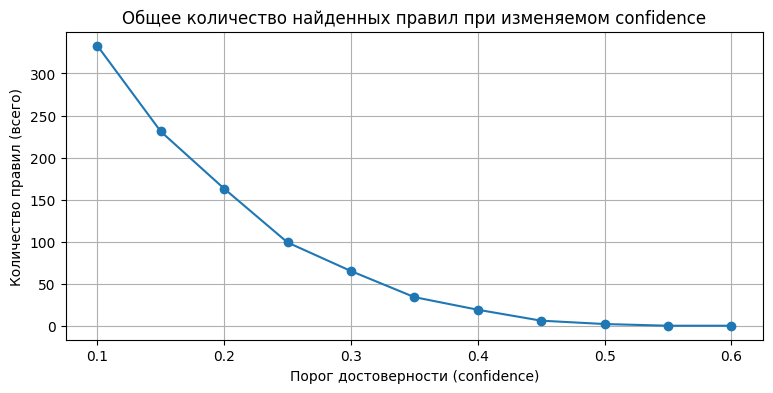

In [10]:
# 2) общее количество правил
plt.figure(figsize=(9,4))
plt.plot(x, results_df["total_rules"], marker="o")
plt.xlabel("Порог достоверности (confidence)")
plt.ylabel("Количество правил (всего)")
plt.title("Общее количество найденных правил при изменяемом confidence")
plt.grid(True)
plt.show()

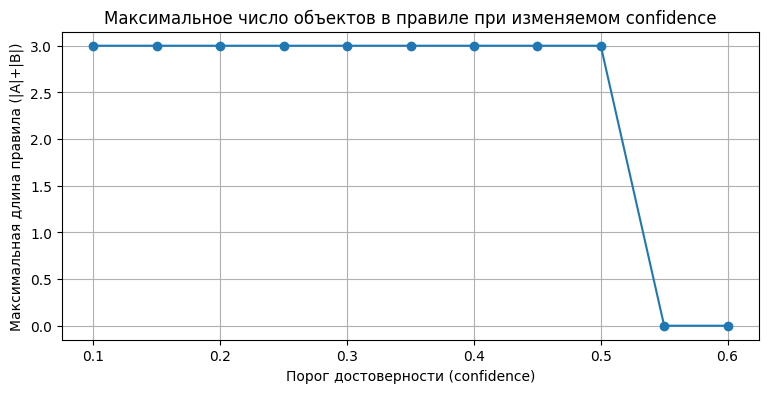

In [11]:
# 3) максимальное число объектов в правиле
plt.figure(figsize=(9,4))
plt.plot(x, results_df["max_rule_length"], marker="o")
plt.xlabel("Порог достоверности (confidence)")
plt.ylabel("Максимальная длина правила (|A|+|B|)")
plt.title("Максимальное число объектов в правиле при изменяемом confidence")
plt.grid(True)
plt.show()

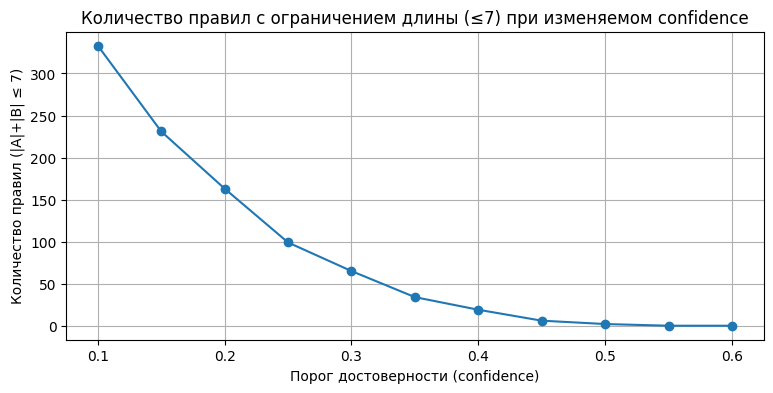

In [12]:
plt.figure(figsize=(9,4))
plt.plot(x, results_df["rules_len_le7"], marker="o")
plt.xlabel("Порог достоверности (confidence)")
plt.ylabel("Количество правил (|A|+|B| ≤ 7)")
plt.title("Количество правил с ограничением длины (≤7) при изменяемом confidence")
plt.grid(True)
plt.show()